In [1]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [3]:
import numpy as np
import pandas as pd

In [2]:
#Movies dataframe
movies_df = pd.read_csv('movies.csv')

#Genome_scores dataframe
gs_df = pd.read_csv('genome_scores.csv')

#Genome_tags dataframe
gt_df = pd.read_csv('genome_tags.csv')

#imbd dataframe
imdb_df = pd.read_csv('imdb_data.csv')

#links dataframe
links_df = pd.read_csv('links.csv')

#tags dataframe
tags_df = pd.read_csv('tags.csv')

#train dataframe
train_df = pd.read_csv('train.csv')

#test dataframe 
test_df = pd.read_csv('test.csv')

#sample submission
sample_df = pd.read_csv('sample_submission.csv')


## Data Description
- Movies -
- Genome_scores - is a score mapping the strength between movies and tag-related properties.
- Genome_tags - User assigned for the movies within the dataset.
- imdb -  Additional movie metadata scraped from IMDB using the links.csv file.
- links - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
- train - The training split of the dataset. Contains user and movie IDs with associated rating data.
- test - The test split of the dataset. Contains user and movie IDs with no rating data.
- sample - Sample of the submission format for the hackathon.

In [11]:
train_df


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837
...,...,...,...,...
10000033,136395,99114,5.0,1521235092
10000034,140078,553,3.0,1002580977
10000035,154807,56782,4.0,1227674807
10000036,85805,327,4.0,1479921530


In [16]:
print("The training data have number rows and columns respectively", train_df.shape)
train_df.info()

The training data have rows and columns respectively (10000038, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [17]:
print(" The test data have number rows and columns respectively", test_df.shape)
test_df.info()

` The test data have rows and columns respectively` (5000019, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [18]:
print(" The movies data have number rows and columns respectively ", movies_df.shape)
movies_df.info()

 The movies data have number rows and columns respectively  (62423, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [20]:
print("The imdb data have number rows and columns respectively ",imdb_df.shape)
imdb_df.info()

The imdb data have number rows and columns respectively  (27278, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [21]:
print(links_df.shape)
links_df.info()

(62423, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [22]:
print(tags_df.shape)
tags_df.info()

(1093360, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


### Splitting the title_casts and genres intoo lists

In [26]:
#extracting released year
movies_eda = movies_df.copy()
movies_eda['release_year']=movies_eda['title'].str[-5:-1] 
#spliting the genres into a list
movies_eda['genres']=movies_eda['genres'].str.split('|') 
#concatinate ratings with movies dataframe
movies_eda.dropna() 
movies_eda.head()

,movieId,title,genres,release_year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


In [24]:
#spliting the title cast into a list
imdb_eda = imdb_df.copy()
imdb_eda['title_cast']=imdb_eda['title_cast'].str.split('|') 
imdb_eda.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...",Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,"[Whitney Houston, Angela Bassett, Loretta Devi...",Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


### Concating the dataset

In [31]:
train_eda = train_df.copy()
con = pd.concat([train_df[:1000],movies_eda], axis=1)
con.head()

,userId,movieId,rating,timestamp,movieId,title,genres,release_year
0,5163.0,57669.0,4.0,1.518350e+09,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,106343.0,5.0,4.5,1.206239e+09,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,146790.0,5459.0,5.0,1.076216e+09,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,106362.0,32296.0,2.0,1.423043e+09,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,9041.0,366.0,3.0,8.333758e+08,5,Father of the Bride Part II (1995),[Comedy],1995


In [32]:
df= pd.concat([imdb_eda,con], axis=1)
df.dropna(inplace=True)
df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords,userId,movieId,rating,timestamp,movieId,title,genres,release_year
0,1.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,5163.0,57669.0,4.0,1.518350e+09,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,106343.0,5.0,4.5,1.206239e+09,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3.0,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...",Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,146790.0,5459.0,5.0,1.076216e+09,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4.0,"[Whitney Houston, Angela Bassett, Loretta Devi...",Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,106362.0,32296.0,2.0,1.423043e+09,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,9041.0,366.0,3.0,8.333758e+08,5,Father of the Bride Part II (1995),[Comedy],1995


### Ratings


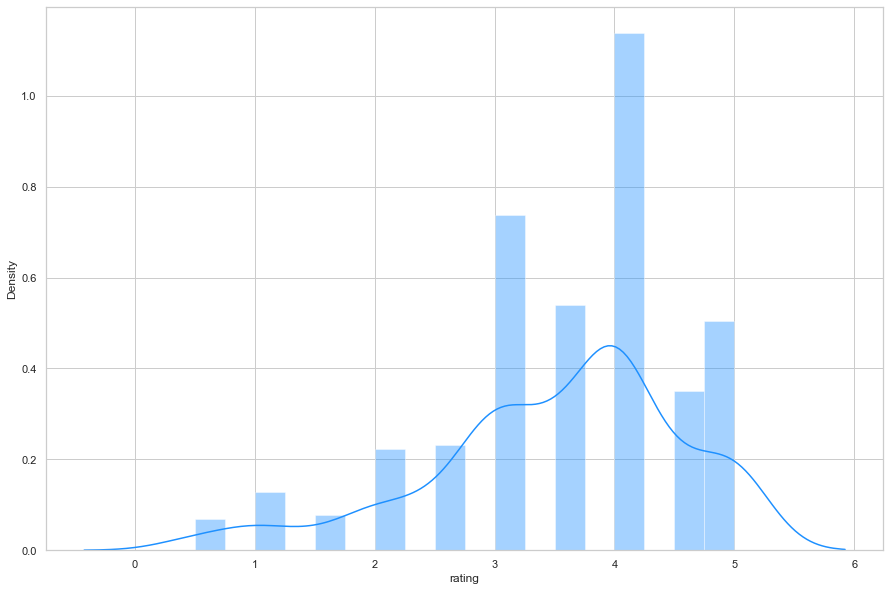

In [45]:
# Distplot of ratings 
sns.distplot(df["rating"], color='dodgerblue');

from the figure above it shows that most movies recieved ratings of 4.

## Genres

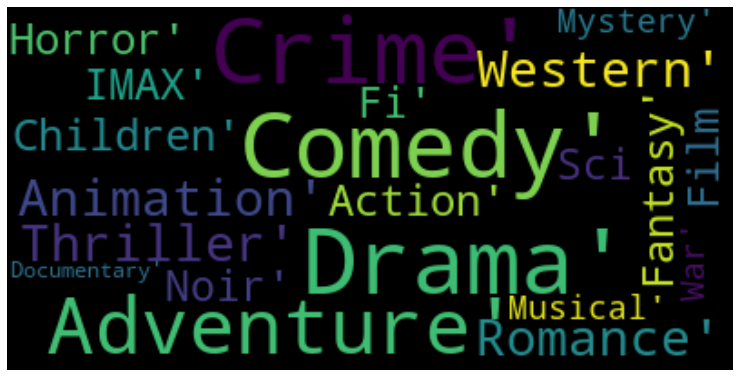

In [81]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
gen = df['genres'].explode()
text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="black").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above it display words, the importance of each word is shown with a font size



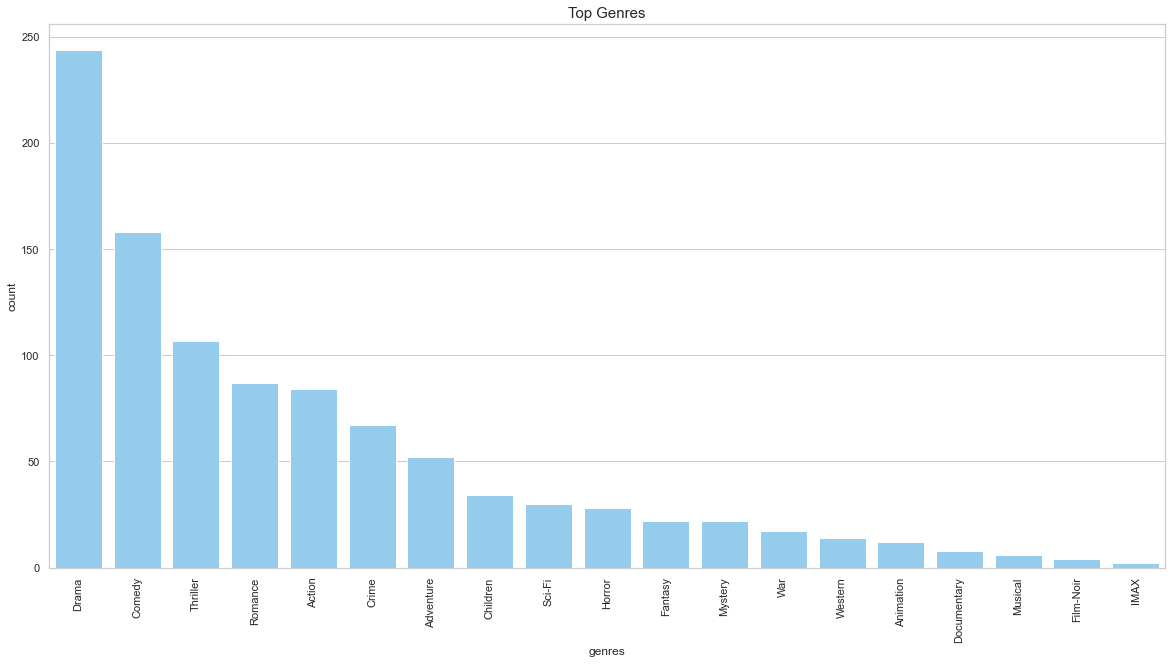

In [87]:
# Ploting top genres in the Dataset
plt.figure(figsize=(20, 10))
gen = df['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color='lightskyblue')
ax.set_title('Top Genres', fontsize=15)
plt.xticks(rotation =90)
plt.show()

### Heatmap

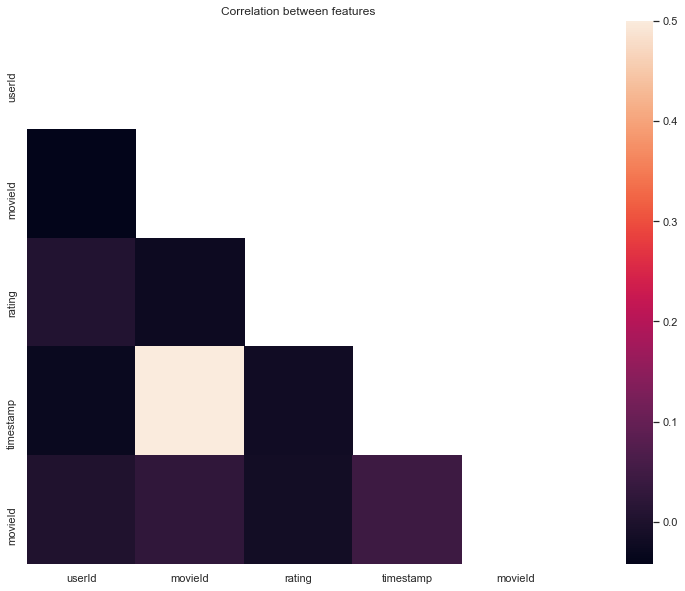

In [68]:
correlation = con.corr()

# create a mask and only show half of the cells 
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True


fig = plt.figure(figsize = (20, 10))

# plot the data using seaborn
ax = sns.heatmap(correlation, 
                 mask = mask, 
                vmax = 0.5, 
                square = True  
                 
                )

ax.set_title("Correlation between features");

The heatmap above shows that most of the variables are less correlated which they range between 0-0.2,the movieId and timestamp variables have a higher correlation compared to the correlation of other variables.